In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#KERAS_BACKEND=tensorflow
#set "KERAS_BACKEND=tensorflow"
from __future__ import print_function
import os
import numpy as np
from skimage.io import imsave, imread
from keras.models import Model
from skimage.transform import resize
from skimage.io import imsave
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt


data_path = 'raw/'        
image_rows = 420
image_cols = 580

In [40]:

def create_train_data():
    train_data_path = os.path.join(data_path, 'train')
    images = os.listdir(train_data_path)
    total = len(images) // 2

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_mask = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        if 'mask' in image_name:
            continue
        image_mask_name = image_name.split('.')[0] + '_mask.tif'
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)
        img_mask = imread(os.path.join(train_data_path, image_mask_name), as_grey=True)

        img = np.array([img])
        img_mask = np.array([img_mask])

        imgs[i] = img
        imgs_mask[i] = img_mask

        #if i % 100 == 0:
        #   print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.............................')

    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', imgs_mask)
    print('Saving to .npy files done.')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():
    train_data_path = os.path.join(data_path, 'test2')
    images = os.listdir(train_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_id = np.ndarray((total, ), dtype=np.int32)

    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    for image_name in images:
        img_id = int(image_name.split('.')[0])
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)

        img = np.array([img])

        imgs[i] = img
        imgs_id[i] = img_id

        i += 1
    print('Loading done..............')

    np.save('imgs_test2.npy', imgs)
    np.save('imgs_id_test2.npy', imgs_id)
    print('Saving to .npy files done.')


def load_test_data():
    imgs_test = np.load('imgs_test2.npy')
    imgs_id = np.load('imgs_id_test2.npy')
    return imgs_test, imgs_id

create_train_data()
create_test_data()

In [4]:
#from keras.models import Model
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)




inputs = Input((img_rows, img_cols, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
model.fit(imgs_train, imgs_mask_train, batch_size=32, nb_epoch=20, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [42]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=32, nb_epoch=20, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    # loading the trained weights for loading in the predict function
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    # creating the masks and saving the image masks as numpy 
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    
def predict():
    create_test_data()
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    # loading the trained weights for loading in the predict function
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    # creating the masks and saving the image masks as numpy 
    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test2.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)


In [43]:
#confirming the backend for keras
K.backend()
predict()

------------------------------
Creating test images...
------------------------------
Loading done..............
Saving to .npy files done.


C:\Users\akuppal\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
5/5 [==============================] - 0s 74ms/step
------------------------------
Saving predicted masks to files...
------------------------------


In [11]:
#training the model and predicting
#train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------


C:\Users\akuppal\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------


C:\Users\akuppal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4508 samples, validate on 1127 samples
Epoch 1/20
4508/4508 [==============================] - 807s 179ms/step - loss: -0.0254 - dice_coef: 0.0254 - val_loss: -0.0204 - val_dice_coef: 0.0204
Epoch 2/20
4508/4508 [==============================] - 836s 186ms/step - loss: -0.0316 - dice_coef: 0.0316 - val_loss: -0.0373 - val_dice_coef: 0.0373
Epoch 3/20
4508/4508 [==============================] - 802s 178ms/step - loss: -0.1837 - dice_coef: 0.1837 - val_loss: -0.1925 - val_dice_coef: 0.1925
Epoch 4/20
4508/4508 [==============================] - 805s 179ms/step - loss: -0.3027 - dice_coef: 0.3027 - val_loss: -0.1510 - val_dice_coef: 0.1510
Epoch 5/20
4508/4508 [==============================] - 776s 172ms/step - loss: -0.3649 - dice_coef: 0.3649 - val_loss: -0.2540 - val_dice_coef: 0.2540
Epoch 6/20
4508/4508 [==============================] - 794s 176ms/step - loss: -0.4051 - dice_coef: 0.4051 - val_loss: -0.2782 - val_dice_coef: 0.2782
Epoch 7/20
4508/4508 [==================

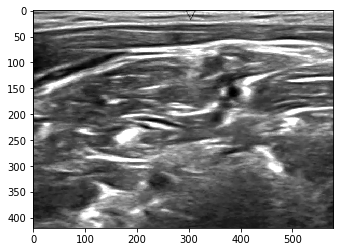

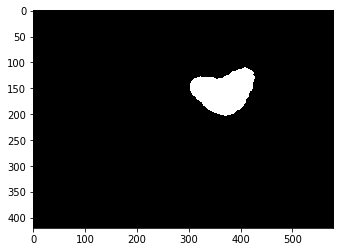

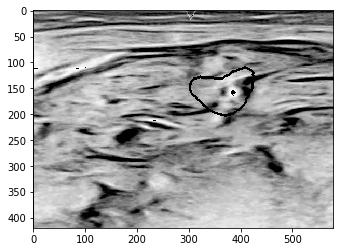

In [48]:
import numpy as np
import cv2

test_array = np.load('imgs_test2.npy')
mask_array = np.load('imgs_mask_test2.npy')
#test_array = np.load('imgs_test.npy')
#mask_array = np.load('imgs_mask_test.npy')

test_id = np.load('imgs_id_test2.npy')
#test_id = np.load('imgs_id_test.npy')
img_idx = 2

test = test_array[img_idx].astype('float32')
mask = mask_array[img_idx].astype('float32')
mask = np.array(mask * 255, dtype = np.uint8)

resized_mask = cv2.resize(mask, (test.shape[1],test.shape[0]))

# contour detection in resized_mask
ret,thresh = cv2.threshold(resized_mask,127,255,0)
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

# apply the overlay
output = test.copy()
output = cv2.cvtColor(output,cv2.COLOR_GRAY2BGR)

# draw the contour
cv2.drawContours(output, contours, -1, (0,0,255), 3)
plt.imshow(test,cmap='gray')
plt.show()
plt.imshow(thresh,cmap='gray')
plt.show()
plt.imshow(output,cmap='gray')
plt.show()
